In [1]:
import numpy as np
import torch

import matplotlib.pylab as plt
from pylightcurve_torch import TransitModule

### Prepare data

In [2]:
time_tensor =  torch.linspace(0,10,500)
pars =  {'e':0.01, 'i':89., 'w':1., 'rp': 0.05, 'method': 'linear', 'ldc': [0.08], 
         'P': 50., 't0': 5., 'a': 5., 'fp': 0.0001}

module = TransitModule(time=time_tensor, **pars)

data = module() + torch.normal(0, 1e-4, time_tensor.shape)

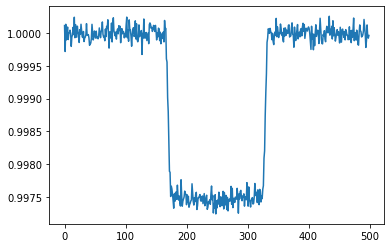

In [3]:
plt.plot(data.T)

# Pyro Model and Guide

In [4]:
import pyro 
import pyro.distributions as dist

def model(flux=None):
    rp_over_rs = pyro.sample("rp_over_rs", dist.Uniform(0., 1))
    mid_time = pyro.sample("mid_time", dist.Uniform(4.5, 5.5))
    sigma = pyro.sample("sigma", dist.Uniform(0.,0.001))

    mean_flux = module.forward(rp_over_rs=rp_over_rs, mid_time=mid_time) #inclination=inclination)  ### * F0
    
    with pyro.plate('data', flux.shape[-1]):
        pred_flux = pyro.sample('obs', dist.Normal(mean_flux, sigma), obs=flux)  #### Check

## HMC

In [5]:
from pyro.infer import MCMC, NUTS

nuts_kernel = NUTS(model)

mcmc = MCMC(nuts_kernel, num_samples=1000, warmup_steps=300)
mcmc.run(data)

Sample: 100%|██████████| 1300/1300 [02:46,  7.80it/s, step size=2.39e-01, acc. prob=0.922]


In [6]:
hmc_samples = {k: v.detach().cpu().numpy() for k, v in mcmc.get_samples().items()}

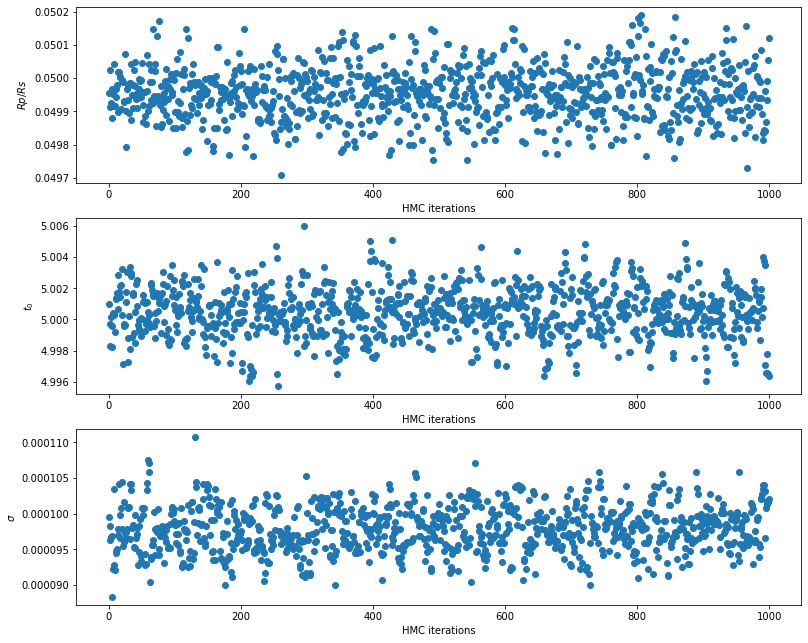

In [19]:
variables  = ['rp_over_rs', 'mid_time', 'sigma']
var_labels = {'rp_over_rs':'$Rp/Rs$', 'mid_time': '$t_0$', 'sigma': '$\sigma$'}

# Show traces
f, ax = plt.subplots(nrows=3, figsize=(13,11))
for i, variable in enumerate(variables):
    ax[i].scatter(range(len(hmc_samples[variable])), hmc_samples[variable])
    ax[i].set_ylabel(var_labels[variable])
    ax[i].set_xlabel('HMC iterations')


# Define a guide for approximate inference

In [66]:
from pyro.infer.autoguide import AutoDiagonalNormal
guide = AutoDiagonalNormal(model)

# SVI

In [67]:
import logging
import pyro.optim as optim
from pyro.infer import SVI, Trace_ELBO


num_steps = 5000
initial_lr = 0.01
gamma = 0.1  # final learning rate will be gamma * initial_lr
lrd = gamma ** (1 / num_steps)
optimiser = pyro.optim.ClippedAdam({'lr': initial_lr, 'lrd': lrd})

svi = SVI(model, guide, optimiser, loss=Trace_ELBO())

pyro.clear_param_store()

for i in range(num_steps):
    elbo = svi.step(data)
    if i % 100 == 0:
        print("Elbo loss: {}".format(elbo))


Elbo loss: 12007739.730549816
Elbo loss: 211278.94935292448
Elbo loss: 4500.140152005566
Elbo loss: -3025.3385466441605
Elbo loss: -3121.0170708539254
Elbo loss: -3193.958811995032
Elbo loss: -3377.347680688831
Elbo loss: -3707.937154822044
Elbo loss: -3856.9591242554284
Elbo loss: -3865.9037367727715
Elbo loss: -3885.4404659779602
Elbo loss: -3881.057168991023
Elbo loss: -3887.7735319121302
Elbo loss: -3885.3592514917646
Elbo loss: -3888.84268680125
Elbo loss: -3888.55815522723
Elbo loss: -3891.710216663814
Elbo loss: -3888.313118556135
Elbo loss: -3889.1629295317707
Elbo loss: -3886.962316071275
Elbo loss: -3887.1945810973084
Elbo loss: -3889.7805773878536
Elbo loss: -3891.3609342943323
Elbo loss: -3889.4425196339917
Elbo loss: -3889.8141264158153
Elbo loss: -3887.97418478432
Elbo loss: -3886.5824350121165
Elbo loss: -3888.276325622788
Elbo loss: -3886.7986519066358
Elbo loss: -3889.1712003395537
Elbo loss: -3889.685630224347
Elbo loss: -3889.5292733155025
Elbo loss: -3889.3090723002

In [68]:
from pyro.infer import Predictive

num_samples = 1000
predictive = Predictive(model, guide=guide, num_samples=num_samples)
svi_samples = {k: v.reshape(num_samples).detach().cpu().numpy()
               for k, v in predictive(data).items()
               if k != "obs"}


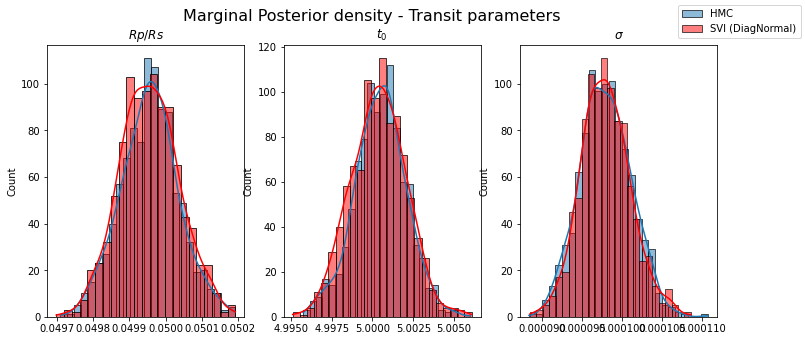

In [69]:
import seaborn as sns
fig, axs = plt.subplots(ncols=len(variables), figsize=(12, 5))

fig.suptitle("Marginal Posterior density - Transit parameters", fontsize=16)
for i, ax in enumerate(axs.reshape(-1)):
    variable = variables[i]
    sns.histplot(hmc_samples[variable], kde=True, ax=ax, label="HMC")
    sns.histplot(svi_samples[variable], kde=True, ax=ax, label="SVI (DiagNormal)", color='red')
    ax.set_title(var_labels[variable])
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

In [70]:
par1, par2 = variables[0], variables[1]

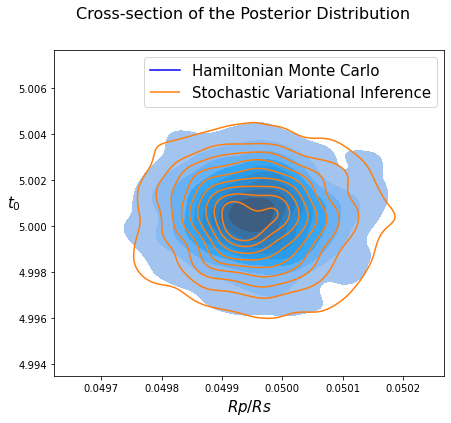

In [72]:
fig, ax = plt.subplots(figsize=(7, 6))
fig.suptitle("Cross-section of the Posterior Distribution", fontsize=16)
sns.kdeplot(x=hmc_samples[par1], y=hmc_samples[par2], ax=ax, shade=True)
# ax.set(xlabel=par1, ylabel=par2, xlim=(0.0497, 0.0503), ylim=(88.96, 89.03))
plt.plot([], color='blue', label="Hamiltonian Monte Carlo")
sns.kdeplot(x=svi_samples[par1], y=svi_samples[par2], ax=ax, label="Stochastic Variational Inference")
# ax.hlines(89, *ax.get_xlim(), color='red', alpha=0.7, ls='dashed', '')
# ax.vlines(0.05, *ax.get_ylim(), color='red', alpha=0.7, ls='dashed')
ax.set_xlabel(var_labels[par1], fontsize=15)
ax.set_ylabel(var_labels[par2], fontsize=15, rotation=0)
ax.legend(fontsize=15)
# plt.show()